# AR Punks
Using an Auto Encoder to generate new punks from old

In [1]:
import sys
sys.path.append('..')
sys.path.append('/home/tnn1t1s/art/cpunks-10k')

import numpy as np
import pandas as pd
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cpunks.cpunks10k as cpunks10k
import cpunks.utils as cputils

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"    
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [3]:
cp = cpunks10k.cpunks10k()
(X_train, Y_train), (X_test, Y_test), (labels) = cp.load_data()
X = np.concatenate((X_train, X_test), axis=0)
df = cp.punks_df

### meta parameters

In [4]:
class ContextManager(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [5]:
def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
ctx = ContextManager({})
ctx.r_loss = r_loss
ctx.learning_rate = 0.0005
ctx.batch_size = 32
ctx.initial_epoch = 0
ctx.input_dim = (24, 24, 4)
ctx.encoder_conv_filters = [32, 64, 64, 64]
ctx.encoder_conv_kernel_size = [3,3,3,3]
ctx.encoder_conv_strides = [1,2,2,1]
ctx.decoder_conv_t_filters = [64,64,32,4]
ctx.decoder_conv_t_kernel_size = [3,3,3,3]
ctx.decoder_conv_t_strides = [1,2,2,1]
ctx.z_dim = 4
ctx.n_layers_encoder = len(ctx.encoder_conv_filters)
ctx.n_layers_decoder = len(ctx.decoder_conv_t_filters)


In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-01-30 18:02:51.692298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 18:02:51.748948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 18:02:51.749211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
encoder_input = Input(shape=ctx.input_dim, 
                      name='encoder_input')

x = encoder_input

for i in range(ctx.n_layers_encoder):
    conv_layer = Conv2D(filters = ctx.encoder_conv_filters[i],
                        kernel_size = ctx.encoder_conv_kernel_size[i],
                        strides = ctx.encoder_conv_strides[i],
                        padding = 'same',
                        name = 'encoder_conv_' + str(i))
    x = conv_layer(x)
    x = LeakyReLU()(x)
    
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(ctx.z_dim, name='encoder_output')(x)
encoder = Model(encoder_input, encoder_output)


### The Decoder

In [9]:
decoder_input = Input(shape=(ctx.z_dim,), name='decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

for i in range(ctx.n_layers_decoder):
    conv_t_layer = Conv2DTranspose(filters = ctx.decoder_conv_t_filters[i],
                                   kernel_size = ctx.decoder_conv_t_kernel_size[i],
                                   strides = ctx.decoder_conv_t_strides[i],
                                   padding = 'same',
                                   name = 'decoder_conv_t_' + str(i))
    x = conv_t_layer(x)
    if i < ctx.n_layers_decoder - 1:
        x = LeakyReLU()(x)
        #x = BatchNormalization()(x)
        #x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

decoder_output = x
decoder = Model(decoder_input, decoder_output)


### Combine to Build the Autoencoder

In [10]:
model_input = encoder_input
model_output = decoder(encoder_output)

model = Model(model_input, model_output)


### Compile

In [11]:
def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

In [12]:
optimizer = Adam(learning_rate=ctx.learning_rate)
model.compile(optimizer=optimizer, loss = r_loss)

### Train

In [13]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

In [14]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))

        return new_lr

    return LearningRateScheduler(schedule)




In [15]:
epochs = 200

initial_epoch = 0
lr_decay = 1

lr_sched = step_decay_schedule(initial_lr=ctx.learning_rate,
                               decay_factor=lr_decay,
                               step_size=1)

callbacks_list = [lr_sched]

model.fit(X_train,
          X_train,
          batch_size = ctx.batch_size,
          shuffle = True,
          epochs = epochs,
          initial_epoch = initial_epoch,
          callbacks = callbacks_list)

Epoch 1/200


2022-01-30 18:03:26.367203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200
2022-01-30 18:03:31.304746: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


282/282 [==============================] - 22s 20ms/step - loss: 0.0527 - lr: 5.0000e-04
Epoch 2/200
282/282 [==============================] - 5s 19ms/step - loss: 0.0212 - lr: 5.0000e-04
Epoch 3/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0175 - lr: 5.0000e-04
Epoch 4/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0159 - lr: 5.0000e-04
Epoch 5/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0146 - lr: 5.0000e-04
Epoch 6/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0138 - lr: 5.0000e-04
Epoch 7/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0132 - lr: 5.0000e-04
Epoch 8/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0127 - lr: 5.0000e-04
Epoch 9/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0123 - lr: 5.0000e-04
Epoch 10/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0120 - lr: 5.0000e-04
Epoch 11/2

282/282 [==============================] - 5s 18ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 83/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 84/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 85/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 86/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 87/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 88/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 89/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 90/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0060 - lr: 5.0000e-04
Epoch 91/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0060 - lr: 5.0000e-04
Epo

282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 163/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 164/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 165/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 166/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 167/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 168/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 169/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 170/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 171/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.000

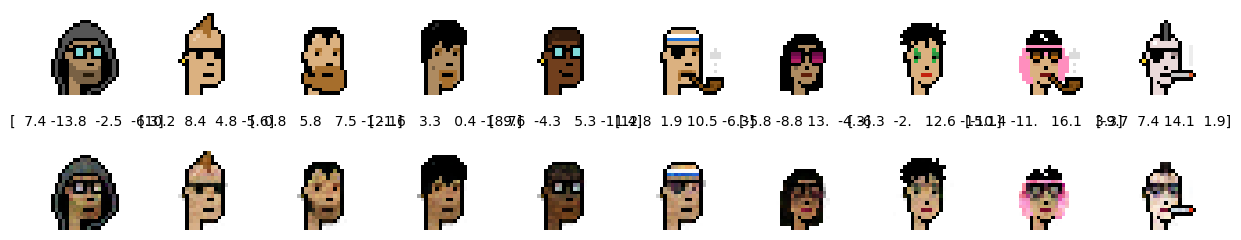

In [16]:
n_to_show = 10
example_idx = np.random.choice(range(len(X_test)), n_to_show)
example_images = X_test[example_idx]

z_points = encoder.predict(example_images)

reconst_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img)

In [17]:
#reconst_images = AE.decoder.predict(z_points)
z_points

array([[  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ],
       [ 10.241212  ,   8.368749  ,   4.796343  ,  -5.5694203 ],
       [  0.79132587,   5.842957  ,   7.545964  , -12.111668  ],
       [ -1.5601897 ,   3.311593  ,   0.39512634, -18.702225  ],
       [  9.647439  ,  -4.27914   ,   5.257742  , -11.377093  ],
       [ 12.844572  ,   1.8600631 ,  10.4856    ,  -6.2996225 ],
       [ -5.831522  ,  -8.7936535 ,  12.963443  ,  -4.3259063 ],
       [ -6.283666  ,  -2.0380917 ,  12.582578  , -15.064583  ],
       [-10.365253  , -11.024603  ,  16.105639  ,   3.2864196 ],
       [ -9.743848  ,   7.4392285 ,  14.104405  ,   1.9254634 ]],
      dtype=float32)

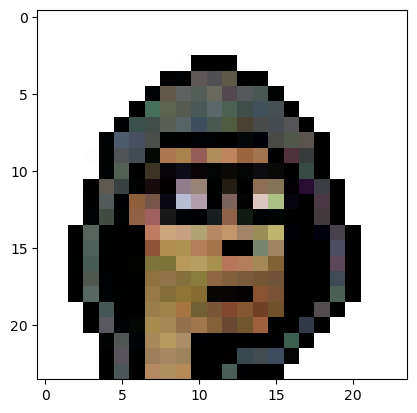

In [24]:
z_s = np.array([[  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ]])
reconst_images = decoder.predict(z_s)
plt.imshow(reconst_images[0])

### pick two punks and do the old face morph trick 

In [155]:
punk_x_img = example_images[0]
punk_y_img = example_images[8]
punk_x_coords = [  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ]
punk_y_coords = [-10.365253  , -11.024603  ,  16.105639  ,   3.2864196 ]

punk_x_coords = [ 10.241212  ,   8.368749  ,   4.796343  ,  -5.5694203 ]
punk_y_coords = [ 12.844572  ,   1.8600631 ,  10.4856    ,  -6.2996225 ]

M=20
x = punk_x_coords
y = punk_y_coords
x = zip(np.linspace(x[0],y[0],M),
        np.linspace(x[1],y[1],M),
        np.linspace(x[2],y[2],M),
        np.linspace(x[3],y[3],M),
       )
z_s = np.array(list(x))
#z_s = np.array([[  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ]])
reconst_images = decoder.predict(z_s)
#plt.imshow(reconst_images[8])

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(M):
    img = reconst_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.imshow(img)

In [156]:
imgs_reversed = np.array([reconst_images[i] for i in range(len(reconst_images) - 1, -1, -1)])
imgs = np.concatenate((reconst_images, imgs_reversed))

In [157]:
import matplotlib.animation as animation
%matplotlib qt

imagelist=imgs 
fig = plt.figure() # make figure

# make axesimage object
# the vmin and vmax here are very important to get the color map correct
im = plt.imshow(imagelist[0]) #, cmap=plt.get_cmap('jet'), vmin=0, vmax=255)

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(imagelist[j])
    # return the artists set
    return [im]
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(40), 
                             interval=48)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

## Reducing Dimensions and staying true to the colorpunx

In [32]:
(mnist_x_train, mnist_y_train), (mnist_x_test, minst_y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [37]:
type(mnist_x_train[0][0][0])

numpy.uint8

In [68]:
type(X_train[0][0][0][0])

numpy.float32

In [143]:
import pickle

class CryptoPunksColorMap:
    def __init__(self):
        with open(f"../data/_colors_count.pickle", 'rb') as f:
            self.colors_count = pickle.load(f)
            self.colors = list(self.colors_count.keys())
            self.color_d = {}
            i=0
            for k in self.colors:
                self.color_d[k] = i
                i+=1
    
    def flatten(self, img):
        return np.array([[self.colors_d[str(c)] for c in row]
                                    for row in img]).astype(np.uint8)
    
    def unflatten(self,img):
        return np.array([[np.fromstring(self.colors[c][1:-1], float, sep=' ') for c in row]
                                                                       for row in img])

cpm = CryptoPunksColorMap()